# (Testing not resizing image in this copy btw)

# Importing Statements

In [153]:
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import os
import seaborn as sns
import splitfolders
import tensorflow as tf


from skimage import feature
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import svm 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow import keras
from skimage.feature import hog
from sklearn.utils import shuffle


# Splitting the Dataset

In [ ]:
input_folder = "dataset"
output_folder = "split_dataset"

splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(0.7,0.1,0.2))
print("Dataset successfully split into training, validating and testing")

In [ ]:
train_path = "split_dataset/train"
val_path = "split_dataset/val"
test_path = "split_dataset/test"     

label_names = ["2", "4", "7", "alpha", "beta", "lim", "pi","pm","theta","times"]  

# Preprocessing Data

In [154]:
def load_data(dataset_path, img_size=(28, 28)):
    data = []
    labels = []
    class_names = sorted(os.listdir(dataset_path))
    
    for label, folder in enumerate(class_names):
        folder_path = os.path.join(dataset_path, folder)
        
        if os.path.isdir(folder_path):
            for file in os.listdir(folder_path):
                file_path = os.path.join(folder_path, file)
                image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
                
                if image is not None:
                    image = cv2.resize(image, img_size)
                    image = image.flatten() / 255.0 
                    data.append(image)
                    labels.append(label)
                    
    return np.array(data), np.array(labels)
                      

X_train, y_train = load_data(train_path)
X_val, y_val = load_data(val_path)
X_test, y_test = load_data(test_path)

X_train, y_train = shuffle(X_train, y_train, random_state=42)
X_val, y_val = shuffle(X_val, y_val, random_state=42)
X_test, y_test = shuffle(X_test, y_test, random_state=42)

In [155]:
print(f"Training images: {X_train.shape[0]}")
print(f"Validation images: {X_val.shape[0]}")
print(f"Test images: {X_test.shape[0]}")

Training images: 3500
Validation images: 500
Test images: 1000


# Implementing HOG Feature Extraction

In [156]:
def hog_features(i):
    hog_features = []
    hog_images = []

    for img in i:
        img_reshaped = img.reshape(28, 28)
        H, hog_image = hog(img_reshaped,
                           orientations=9,
                           pixels_per_cell=(10, 10),
                           cells_per_block=(2, 2),
                           block_norm='L2-Hys',
                           transform_sqrt=True,
                           visualize=True)
        hog_features.append(H)
        hog_images.append(hog_image)

    return np.array(hog_features), np.array(hog_images)


In [157]:
X_train_hog, X_train_hog_images = hog_features(X_train)
X_test_hog, X_test_hog_images = hog_features(X_test)
X_val_hog, X_val_hog_images = hog_features(X_val)


HOG Image Visualisation

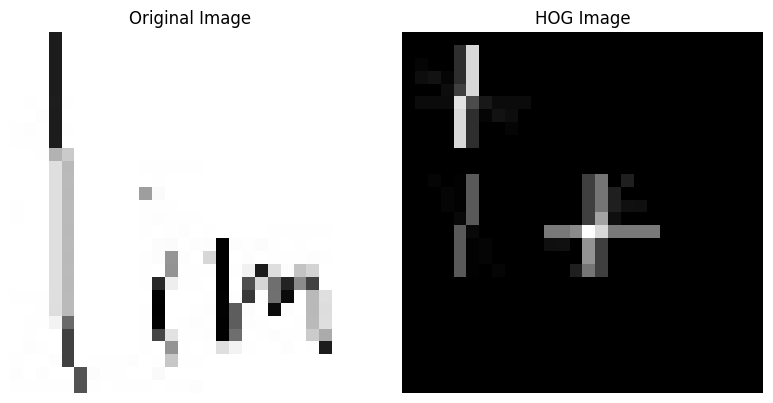

In [160]:
index = np.random.randint(0, len(X_train))

#Original Image
img = X_train[index].reshape(28, 28)

#HOG Image
H, hog_img = hog(img,
                   orientations=9,
                   pixels_per_cell=(10, 10),
                   cells_per_block=(2, 2),
                   block_norm='L2-Hys',
                   transform_sqrt=True,
                   visualize=True)

#Plotting both images
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.title(f"Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(hog_img, cmap='gray')
plt.title("HOG Image")
plt.axis('off')

plt.tight_layout()
plt.show()

# SVM classifier

In [ ]:
model_hog = svm.SVC(kernel='rbf', C=10.0, random_state=42)
model_hog.fit(X_train_hog, y_train)

print("Train set Accuracy: {:.3f}".format(model_hog.score(X_train_hog, y_train)))

Train set Accuracy: 0.995
Test set Accuracy: 0.915


# SVM Results

Classification Report

In [162]:
y_pred = model_hog.predict(X_test_hog)

print("Classification Report (SVM):\n")
print(classification_report(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
print("Final Accuracy: {:.3f}".format(accuracy))


Classification Report (SVM):

              precision    recall  f1-score   support

           0       0.91      0.89      0.90       100
           1       0.84      0.84      0.84       100
           2       0.91      0.88      0.89       100
           3       0.88      0.96      0.92       100
           4       0.87      0.97      0.92       100
           5       0.94      0.93      0.93       100
           6       0.95      0.94      0.94       100
           7       0.97      0.97      0.97       100
           8       0.90      0.84      0.87       100
           9       0.99      0.93      0.96       100

    accuracy                           0.92      1000
   macro avg       0.92      0.91      0.91      1000
weighted avg       0.92      0.92      0.91      1000

Final Accuracy: 0.915


Confusion Matrix

[[89  0  2  2  1  1  3  0  1  1]
 [ 1 84  4  1  2  3  0  0  5  0]
 [ 5  2 88  0  1  0  2  2  0  0]
 [ 1  1  0 96  0  1  0  0  1  0]
 [ 0  1  0  0 97  0  0  0  2  0]
 [ 0  5  0  2  0 93  0  0  0  0]
 [ 1  2  0  3  0  0 94  0  0  0]
 [ 0  2  1  0  0  0  0 97  0  0]
 [ 0  1  1  4  9  1  0  0 84  0]
 [ 1  2  1  1  1  0  0  1  0 93]]


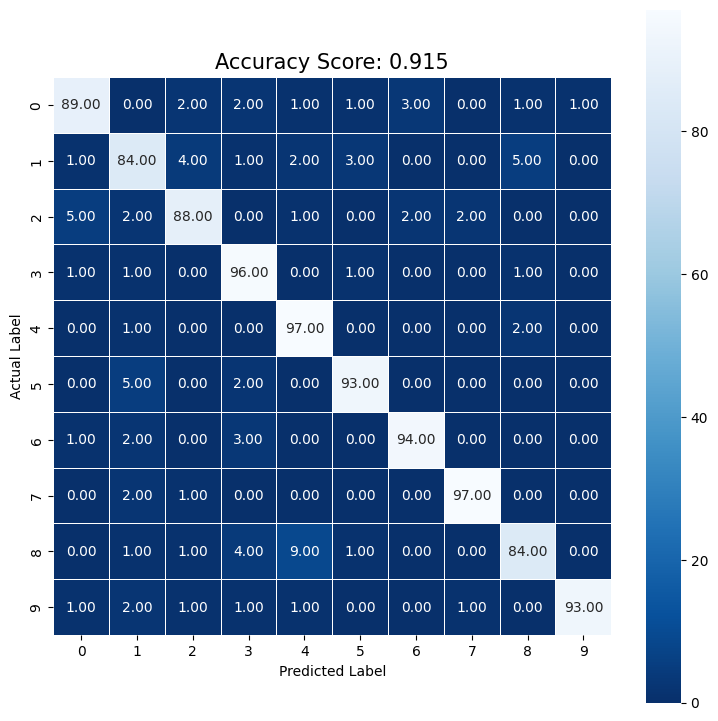

In [163]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".2f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
all_sample_title = 'Accuracy Score: {0}'.format(accuracy)
plt.title(all_sample_title, size = 15);
plt.show()

Visualisation of testing data

alpha
alpha
theta
lim


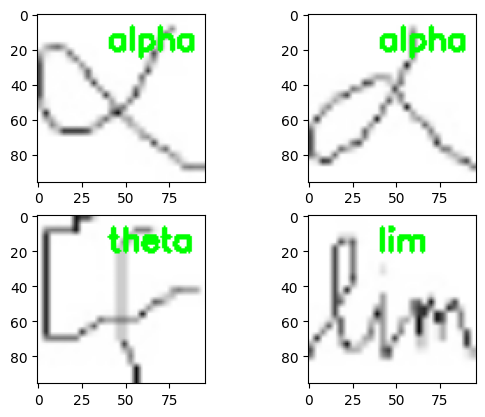

In [ ]:
pp_images = []
pp_labels = []

for i in np.random.choice(np.arange(0, len(y_test)), size=16):
    test_img = X_test[i].reshape(28, 28) * 255.0 
    test_img = test_img.astype(np.uint8)
    
    pred = model_hog.predict(X_test_hog[i].reshape(1, -1))[0]
    
    label = label_names[pred] if label_names else str(pred)
    pp_labels.append(label)    
    img_view = cv2.resize(test_img, (96, 96), interpolation=cv2.INTER_LINEAR)
    img_view = cv2.cvtColor(img_view, cv2.COLOR_GRAY2BGR)
    cv2.putText(img_view, label, (40, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
    
    pp_images.append(img_view)
    
fig = plt.figure()
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(pp_images[1])
print(pp_labels[1])
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(pp_images[2])
print(pp_labels[2])
ax3 = fig.add_subplot(2,2,3)
ax3.imshow(pp_images[3])
print(pp_labels[3])
ax4 = fig.add_subplot(2,2,4)
ax4.imshow(pp_images[4])
print(pp_labels[4])

# ANN Classifier

In [142]:
num_classes = len(np.unique(y_train))

model_hog = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train_hog.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model_hog.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

H = model_hog.fit(
    X_train_hog, y_train,
    validation_data=(X_val_hog, y_val),
    epochs=20,
    batch_size=32
)

Epoch 1/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2624 - loss: 2.1635 - val_accuracy: 0.6040 - val_loss: 1.5220
Epoch 2/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step - accuracy: 0.6267 - loss: 1.3283 - val_accuracy: 0.6860 - val_loss: 1.0635
Epoch 3/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step - accuracy: 0.6886 - loss: 0.9715 - val_accuracy: 0.7160 - val_loss: 0.9021
Epoch 4/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step - accuracy: 0.7242 - loss: 0.8436 - val_accuracy: 0.7600 - val_loss: 0.8116
Epoch 5/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7504 - loss: 0.7627 - val_accuracy: 0.7540 - val_loss: 0.7597
Epoch 6/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7704 - loss: 0.6984 - val_accuracy: 0.7720 - val_loss: 0.7228
Epoch 7/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step - accuracy: 0.7560 - loss: 0.6978 - val_accuracy: 0.7960 - val_loss: 0.6792
Epoch 8/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step - accuracy: 0.7855 - loss: 0.6314 - val_ac

# ANN Results

In [130]:
model_hog.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 328,160 (1.25 MB)

 Trainable params: 109,386 (427.29 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 218,774 (854.59 KB)

Classification Report

In [144]:
y_pred_probs = model_hog.predict(X_test_hog)
y_pred_ann = np.argmax(y_pred_probs, axis=1)

print("Classification Report (ANN):")
print(classification_report(y_test, y_pred_ann))

accuracy = accuracy_score(y_test, y_pred_ann)
print("Final Accuracy: {:.3f}".format(accuracy))

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Classification Report (ANN):
              precision    recall  f1-score   support

           0       0.80      0.82      0.81       100
           1       0.76      0.72      0.74       100
           2       0.86      0.67      0.75       100
           3       0.83      0.86      0.85       100
           4       0.78      0.79      0.79       100
           5       0.83      0.90      0.87       100
           6       0.88      0.86      0.87       100
           7       0.81      0.88      0.85       100
           8       0.77      0.80      0.78       100
           9       0.90      0.93      0.92       100

    accuracy                           0.82      1000
   macro avg       0.82      0.82      0.82      1000
weighted avg       0.82      0.82      0.82      1000

Final Accuracy: 0.823


Confusion Matrix

[[82  0  1  2  4  1  5  1  1  3]
 [ 1 72  3  3  5  8  0  2  6  0]
 [ 8  5 67  3  1  1  4 11  0  0]
 [ 2  3  0 86  0  3  1  0  2  3]
 [ 1  3  0  0 79  0  0  1 13  3]
 [ 1  5  0  3  0 90  0  0  1  0]
 [ 4  1  1  2  0  1 86  4  0  1]
 [ 0  1  5  0  1  3  1 88  1  0]
 [ 2  2  1  2 10  1  1  1 80  0]
 [ 1  3  0  2  1  0  0  0  0 93]]


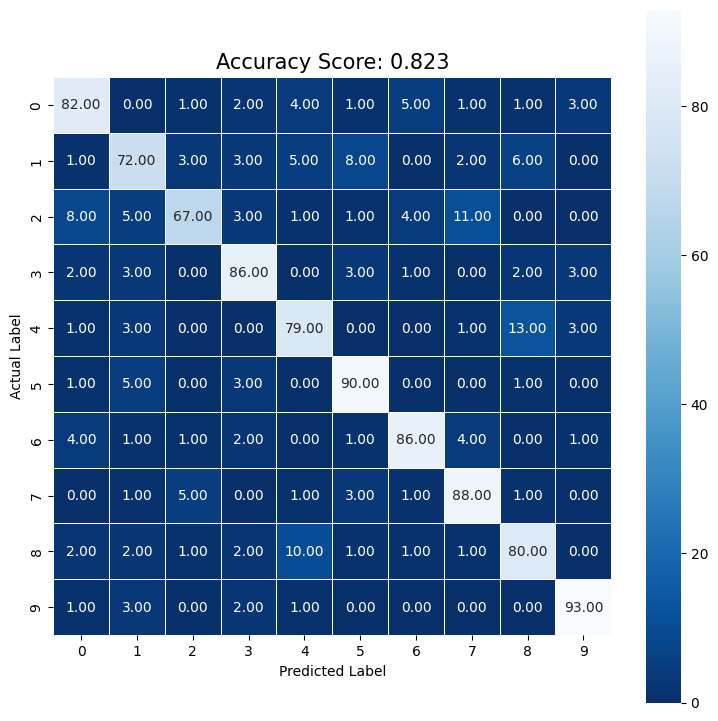

In [147]:
cm = confusion_matrix(y_test, y_pred_ann)
print(cm)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".2f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
all_sample_title = 'Accuracy Score: {0}'.format(accuracy)
plt.title(all_sample_title, size = 15);
plt.show()